In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [46]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [47]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb7aa85a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ffb7aab6828>]], dtype=object)

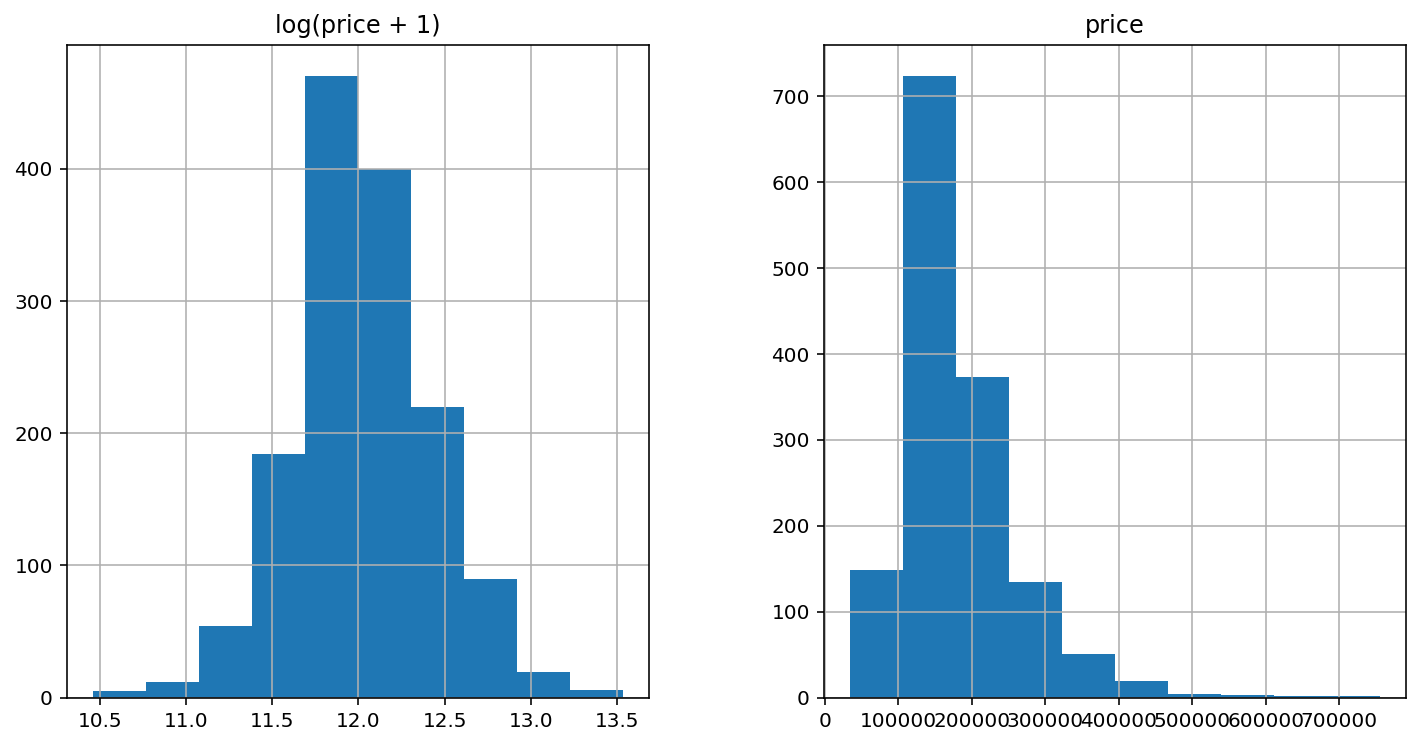

In [48]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [49]:
train["SalePrice"] = np.log1p(train["SalePrice"])
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [50]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [51]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [52]:
all_data_2 = X_train
all_data_2['SalePrice'] = y
corrmat = all_data_2.corr()
cols = corrmat.nlargest(200,'SalePrice')['SalePrice'].index
cols=cols[1:]
X_train = X_train[cols]
X_test = X_test[cols]

/home/pawan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
from sklearn.model_selection import train_test_split
X_train_train, X_train_test, y_train, y_test = train_test_split(X_train.as_matrix(), y.as_matrix(), test_size=0.0001)

In [54]:
from sklearn.cross_validation import cross_val_score
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) 
scores = cross_val_score(estimator=model_xgb,X=X_train_train,y=y_train,cv=20,n_jobs=-1)

In [55]:
print(scores.mean(),"-+",scores.std())

0.896731096736 -+ 0.036612081372


In [56]:
model_xgb.fit(X_train_train, y_train)
model_xgb.score(X_train_test,y_test)
my_imputer = Imputer()
X_test = my_imputer.fit_transform(X_test)

In [57]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

In [58]:
Id = test['Id']
sub = pd.DataFrame()
sub['Id'] =Id
sub['SalePrice']=xgb_preds
sub.to_csv("Model3.csv",index=False)